# 빅쿼리

In [57]:
from google.cloud import bigquery
import pandas as pd
import os
from google.oauth2 import service_account
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

# 서비스 계정 키 파일 경로 가져오기
key_path = "/Users/peterpanz/Desktop/kpi/config/YOUR_GCP_API_KEY.json"

if not key_path:
    raise FileNotFoundError("환경 변수 'GOOGLE_GA4_APPLICATION_CREDENTIALS'가 설정되지 않았습니다.")


# Credentials 객체 생성
default_credentials = service_account.Credentials.from_service_account_file(key_path)

def fetch_data_from_bigquery(query, credentials=default_credentials):
    """
    Google BigQuery에서 데이터를 조회하여 pandas DataFrame으로 반환하는 함수.

    Parameters:
    ----------
    query : str
        실행할 SQL 쿼리 (예: "SELECT * FROM dataset.table LIMIT 10").
    credentials : google.oauth2.service_account.Credentials, optional
        BigQuery 인증에 사용할 서비스 계정 객체 (기본값: default_credentials).

    Returns:
    -------
    pandas.DataFrame
        실행된 쿼리의 결과를 포함하는 DataFrame.

    Raises:
    ------
    google.api_core.exceptions.GoogleAPIError
        BigQuery API 요청 중 발생할 수 있는 오류.
    FileNotFoundError
        credentials 파일이 설정되지 않았거나 찾을 수 없는 경우 발생.

    Example:
    --------
    >>> query = "SELECT event_name FROM `project.dataset.events` LIMIT 100"
    >>> df = fetch_data_from_bigquery(query)
    >>> print(df.head())

    Notes:
    ------
    - 기본적으로 `GOOGLE_APPLICATION_CREDENTIALS` 환경 변수가 설정되어 있어야 BigQuery 인증이 가능함.
    - credentials를 직접 전달하지 않으면 `default_credentials`를 사용하여 인증함.
    """
    # GCP 클라이언트 객체 생성
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)

    # 쿼리 실행
    query_job = client.query(query)

    # 결과를 pandas DataFrame으로 변환
    results = query_job.result()
    df = results.to_dataframe()

    return df


In [77]:
query = """
    WITH filtered_events AS (
    SELECT
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'house_id') AS house_id,
        event_name,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'sticker_category') AS sticker_category,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'platform') AS platform,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_id') AS page_id,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'building_type') AS building_type,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'contract_type') AS contract_type,
        (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'deposit') AS deposit,
        (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'monthly_fee') AS monthly_fee
    FROM
        `project.dataset.events_*`
    WHERE
        event_name IN ('view_house_detail', 'inquiry_submitted')
        AND (SELECT value.string_value
            FROM UNNEST(event_params)
            WHERE key = 'platform') != 'mw'
        AND event_date BETWEEN '20250520' AND '20250603'
    ),

    labeled_events AS (
    SELECT
        house_id,
        event_name,
        page_id,
        building_type,
        contract_type,
        deposit,
        monthly_fee,
        CASE
        WHEN sticker_category IS NOT NULL THEN 'premium'
        ELSE 'general'
        END AS group_label
    FROM
        filtered_events
    ),

    aggregated AS (
    SELECT
        house_id,
        group_label,
        SUM(CASE WHEN event_name = 'view_house_detail' THEN 1 ELSE 0 END) AS pv_count,
        SUM(CASE WHEN event_name = 'inquiry_submitted' AND page_id = 'PAGE_HOUSE_DETAIL' THEN 1 ELSE 0 END) AS inquiry_count,
        building_type,
        contract_type,
        deposit,
        monthly_fee
    FROM
        labeled_events
    GROUP BY
        house_id,
        group_label,
        building_type,
        contract_type,
        deposit,
        monthly_fee
    )

    SELECT
    house_id,
    group_label AS `group`,
    pv_count,
    inquiry_count,
    building_type,
    contract_type,
    deposit,
    monthly_fee
    FROM
    aggregated
    ORDER BY
    house_id,
    `group`
        """

In [ ]:
df = fetch_data_from_bigquery(query)
df = df.loc[df['hidx'].notna()].reset_index(drop=True)

## 전처리
- 시도 전처리
- 종속변수 설계
- 불균형 문제 해결

In [146]:
df['sido'] = df['sido'].replace({'강원도': '강원특별자치도', '전라북도': '전북특별자치도', '광주시': '광주광역시','부산시':'부산광역시'})
df['sido'].unique()

In [156]:
# 샘플링: undersample general
from sklearn.utils import resample

general_df = df[df['group'] == 'general']
premium_df = df[df['group'] == 'premium']

general_downsampled = resample(general_df, replace=False, n_samples=len(premium_df), random_state=42)
balanced_df = pd.concat([general_downsampled, premium_df])

In [159]:
def region_category(x):
    if x == '서울특별시':
        return '서울'
    elif x == '부산광역시':
        return '부산'
    elif x == '경기도':
        return '경기'
    else:
        return '기타'

balanced_df['region_category'] = balanced_df['sido'].apply(region_category)

In [ ]:
# cvr 계산 (0으로 나누는 오류 방지)
df = df[df['pv_count'] > 0].copy()
df['cvr'] = df['inquiry_count'] / df['pv_count']

In [ ]:
# 월세 -> 월새 * 300으로 보증금으로 환산
df['deposit'] = df['deposit'] + df['monthlt_fee'] * 300

### 다중공성선

In [263]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# 더미화
X = pd.get_dummies(
    balanced_df[['group', 'building_type', 'contract_type', 'region_category']],
    drop_first=True
)
X['adjusted_deposit'] = balanced_df['adjusted_deposit']

# 숫자형 강제 변환
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)
X = X.astype(float)

# 상수항 추가
import statsmodels.api as sm
X = sm.add_constant(X)

# VIF 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


                 feature        VIF
0                  const  28.007933
6       contract_type_월세   3.995199
7       contract_type_전세   2.946174
5       contract_type_매매   2.582197
10    region_category_서울   2.213238
9     region_category_부산   2.108931
8     region_category_기타   2.012224
3      building_type_아파트   1.377843
4     building_type_오피스텔   1.175526
1          group_premium   1.094130
2   building_type_상가/사무실   1.027076
11      adjusted_deposit   1.002314


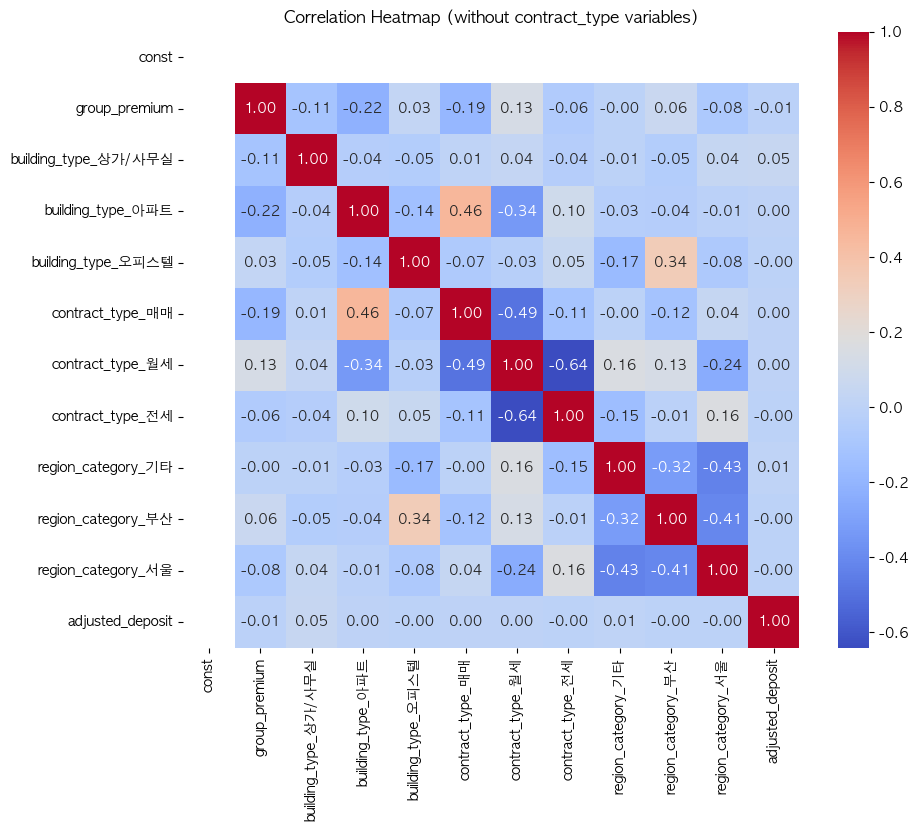

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = X.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap (without contract_type variables)')
plt.show()


### 평가

In [276]:
import statsmodels.formula.api as smf

# 최종 데이터셋
model_df = balanced_df.copy()

# 회귀 분석
formula = 'pv_count ~  C(group) + C(building_type) + adjusted_deposit + C(sido)'

model = smf.ols(formula, data=model_df.loc[model_df['contract_type'] != '월세']).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               pv_count   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     44.25
Date:                Mon, 02 Jun 2025   Prob (F-statistic):          2.41e-174
Time:                        18:13:08   Log-Likelihood:                -47945.
No. Observations:                9542   AIC:                         9.593e+04
Df Residuals:                    9520   BIC:                         9.609e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [277]:
import statsmodels.formula.api as smf

# 최종 데이터셋
model_df = balanced_df.copy()

# 회귀 분석
formula = 'inquiry_count ~ C(group) + C(building_type) + C(sido) + adjusted_deposit'

model = smf.ols(formula, data=model_df.loc[model_df['contract_type'] != '월세']).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          inquiry_count   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     14.69
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           4.92e-52
Time:                        18:14:19   Log-Likelihood:                -11602.
No. Observations:                9542   AIC:                         2.325e+04
Df Residuals:                    9520   BIC:                         2.341e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [278]:
import statsmodels.formula.api as smf

# 최종 데이터셋
model_df = balanced_df.copy()

# 회귀 분석
formula = 'cvr ~  C(group) + C(building_type) +  C(sido) + adjusted_deposit'

model = smf.ols(formula, data=model_df.loc[model_df['contract_type'] != '월세']).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cvr   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.618
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.16e-11
Time:                        18:15:08   Log-Likelihood:                 18847.
No. Observations:                9542   AIC:                        -3.765e+04
Df Residuals:                    9520   BIC:                        -3.749e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           